In [ ]:
print("The start of Optimisation HW1!")
print("These are not the droids you're looking for")

In [102]:
#Import relevant libraries
import sklearn
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import scipy.linalg
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time

In [84]:
random.seed(69)
np.random.seed(69)

In [99]:
def createDataset():
    #Let's start to generate the points using two functions: sine and cosine
    range = (-5*np.pi, 5*np.pi)
    n = 5000 #number of points
    x_0 = np.random.uniform(*range, n//2)
    f_sin = np.sin(0.6*x_0) #function for class -1
    f_cos = np.cos(0.6*x_0+np.pi/2) #fuction for class 1

    #Visualize the graphs without noise
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Graphs of sin and cos without noise")
    plt.scatter(x_0, f_sin, alpha=0.6, s=30, color="m")
    plt.scatter(x_0, f_cos, alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-15, 15)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    #Let's add some noise 
    noise = np.random.normal(0, 0.1, len(x_0))
    new_fsin = f_sin + noise
    new_fcos = f_cos + noise 

    #Graphs visualization with noise 
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Graphs of sin and cos with noise")
    plt.scatter(x_0, new_fsin, alpha=0.6, s=30, color="m")
    plt.scatter(x_0, new_fcos, alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-15, 15)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    class_0 = np.array(list(zip(x_0, new_fsin)))
    class_1 = np.array(list(zip(x_0, new_fcos)))

    return class_0, class_1

def split_data(class0, class1, labeled_pct, initialize_random=True):
    scaler = StandardScaler().fit(np.concatenate((class0, class1)))
    split_0 = int(len(class0) * labeled_pct) #number of data with labels according to percentage provided for class 0
    split_1 = int(len(class1) * labeled_pct) #same for class 1

    x_bar_0 = scaler.transform(class0[:split_0]) #transforms on the range of the labeled data 
    x_bar_1 = scaler.transform(class1[:split_1])
    x_0 = scaler.transform(class0[split_0:]) #transforms on the range of the unlabeled data 
    x_1 = scaler.transform(class1[split_1:])

    #Creating the labels and variables for label and unlabel data 
    y_bar_0 = np.full(len(x_bar_0), -1) #assigns -1 to a vector of size x_bar_0, creating labeled data for class -1
    y_bar_1 = np.full(len(x_bar_1), 1)  #assigns 1 to a vector of size x_bar_1, creating labeled data for class 1 
    y_0 = np.full(len(x_0), -1) #creating the target vector for class -1
    y_1 = np.full(len(x_1), 1) #creating the target vector for class 1 

    #Concatenates variables of both classes to create label and unlabel variables 
    x_labeled = np.concatenate((x_bar_0, x_bar_1)) #list of coordinates (x, y) of labeled data 
    y_labeled = np.concatenate((y_bar_0, y_bar_1)) #list of classes 
    x_unlabeled = np.concatenate((x_0, x_1)) #list of coordiantes (x, y) of unlabeled data
    y_unlabeled_target = np.concatenate((y_0, y_1)) #list of target classes

    #2 ways to initialize the labels to predict 
    if initialize_random:
        y_unlabeled_initial = np.random.choice([-1, 1], len(x_unlabeled))
    else:
        y_unlabeled_initial = np.zeros(len(x_unlabeled))

    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial

def plottingData(x_labeled, y_labeled, x_unlabeled, y_unlabeled_target):
    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Unlabeled points true value")
    plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Labeled points true value")
    plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.figure(figsize=(8, 4), dpi=100)
    plt.title("Labeled and unlabeled points")
    plt.scatter([p[0] for p in x_unlabeled], [p[1] for p in x_unlabeled], c="grey")
    plt.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]], alpha=0.6, s=30, color="m")
    plt.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]], alpha=0.6, s=30, color="c")
    plt.legend(["Unlabeled", "Labeled -1", "Labeled 1"])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    return 

def prepareArtifitialData():
    class0, class1 = createDataset()
    x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial = split_data(class0, class1, 0.1)
    plottingData(x_labeled, y_labeled, x_unlabeled, y_unlabeled_target)
    return x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial

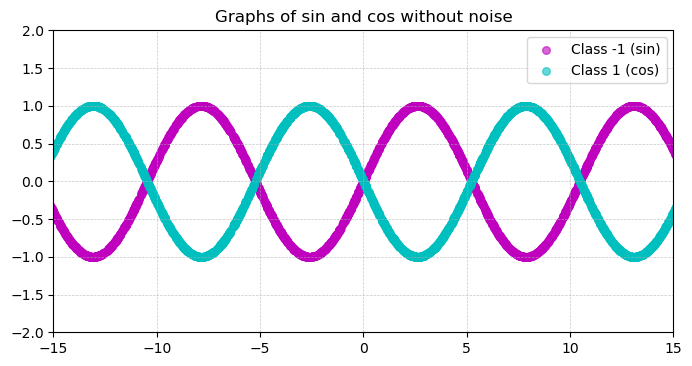

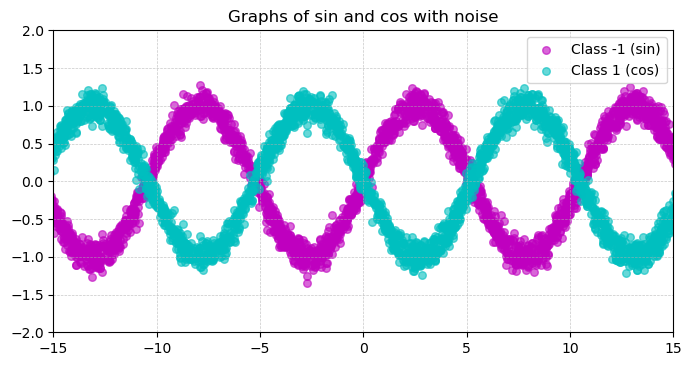

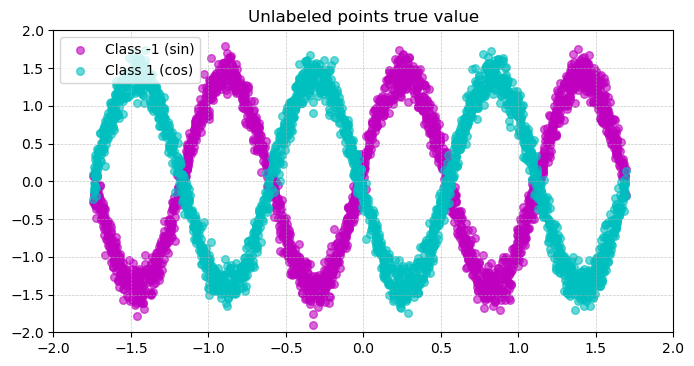

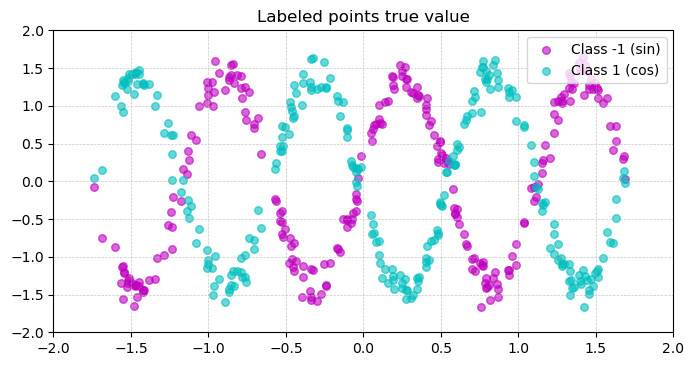

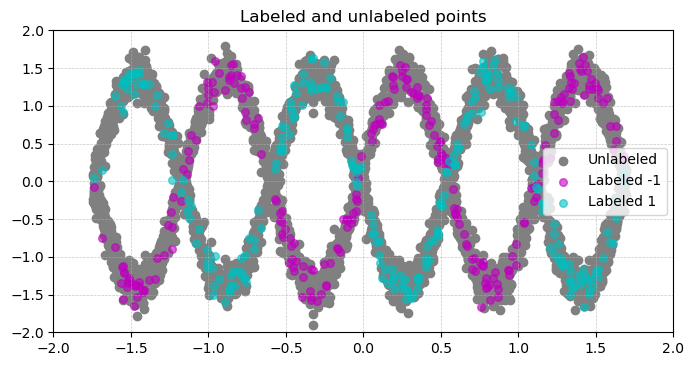

In [100]:
x_labeled, y_labeled, x_unlabeled, y_unlabeled_target, y_unlabeled_initial = prepareArtifitialData()

In [103]:
# Define weight arrays using Gaussian (RBF) Kernel as similarity measure 

#Array w_ij is the weights array between labeled examples and unlabeled examples
dist_labeled_unlabeled = cdist(x_labeled, x_unlabeled, metric='euclidean')
w_ij = np.exp(-0.5 * dist_labeled_unlabeled ** 2)

#Array w_ij_bar is the weights array between unlabeled examples and unlabeled examples
dist_unlabeled_unlabeled = cdist(x_unlabeled, x_unlabeled, metric='euclidean')
w_ij_bar = np.exp(-0.5 * dist_unlabeled_unlabeled ** 2)

print(w_ij.shape, w_ij_bar.shape)

(500, 4500) (4500, 4500)


In [106]:
w_ij_bar[0:5]

array([[1.        , 0.00575023, 0.99506159, ..., 0.01756526, 0.00207413,
        0.04631757],
       [0.00575023, 1.        , 0.00495692, ..., 0.01323396, 0.13720561,
        0.35772312],
       [0.99506159, 0.00495692, 1.        , ..., 0.02022485, 0.00215914,
        0.04580109],
       [0.54929193, 0.03845684, 0.56530542, ..., 0.20010233, 0.05002769,
        0.32853462],
       [0.08225222, 0.0547471 , 0.08891944, ..., 0.76636022, 0.34353729,
        0.61696605]])

In [107]:
#Implement BCGD

#First, define the loss function

def loss(given_labels, predicted_labels):
    
   #Representing points as vectors for ease of calculations
    y = np.copy(predicted_labels).astype("float64").reshape((-1,1))
    y_bar = np.copy(given_labels).astype("float64").reshape((-1,1))

    diff_t1 = y-y_bar.T
    diff_t1_sq = np.power(diff_t1,2)
    loss_matrix_t1 = diff_t1_sq*w_ij.T
    total_loss_t1 = np.sum(loss_matrix_t1)

    diff_t2 = y-y.T
    diff_t2_sq = np.power(diff_t2,2)
    loss_matrix_t2 = diff_t2_sq*w_ij_bar.T
    total_loss_t2 = np.sum(loss_matrix_t2)

    return total_loss_t1 + total_loss_t2


In [108]:
#Define accuracy measures
# accuracy score, rounding current to {-1,1} and comparing with target
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)

# accuracy from a loss point of view, however it has the problem that
# the minimum of the loss might be greater than 0
max_loss = np.sum(w_ij) * 4 + np.sum(w_ij_bar) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

# accuracy from a target point of view, aka distance from current to target
initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=1)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=1)
    return 1 - current_distance / initial_distance

# the accuracy used as proxy to switch from one to another
def accuracy(current):
    return accuracy_norm(current)

def accuracy2(current_prediction):
    return accuracy_score(y_unlabeled_target, current_prediction)

In [109]:
#Define Hessian Matrix to estimate Lipschitz constant

USE_LIPSCHITZ_CONSTANT = True
OUTPUT_STEP = 0.1
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
STEP_SIZE = 1e-2

def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]) - w_unlabeled_unlabeled[i][i]
    print()
    return mat * 2

def estimate_lipschitz_constant(hessian):
    # max eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

def estimate_degree_strongly_convex(hessian):
    # min eigvalue
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(w_ij_bar, w_ij)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 306.9956773758897,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 4313.832162879645
Estimating Lipschitz constant for each single variable
Done


In [110]:
#Calculating constants that will be used in the Gradient Descent Method

print("Calculating coefficients of the gradient")
row_sum_w = np.sum(w_ij, axis=0).reshape((-1,1))
row_sum_w_ = np.sum(w_ij_bar, axis=0).reshape((-1,1))
Cij = (row_sum_w + row_sum_w_)
b = np.multiply(
    y_labeled.reshape((-1,1)),
    w_ij
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


In [111]:
#Defining the gradient function

def gradient(y):
    unlabeled = y.reshape((-1,1))
    third_coeff = np.dot(w_ij_bar.T, unlabeled)
    return 2 * (Cij * unlabeled - b - third_coeff).reshape((-1,))

In [112]:
#Defining functions for the gradient calculation for block selection

def derivative(y, j):
    return 2 * (Cij[j] * y[j] -
           b[j] -
           np.matmul(w_ij_bar[:,j], y.T))

def update_gradient(previous_grad, Li, index):
    global w_ij_bar, Cij
    step = 1/Li * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += 2* w_ij_bar[index] * step
    new_grad[index] -= 2 * Cij[index] * step
    return step, new_grad

In [137]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [138]:
print(y_unlabeled_gd[0:10])

[-1 -1 -1 -1 -1 -1  1  1  1  1]


In [139]:
#Implementation of GD
NUM_ITERS=50

ticks_gd = [0]
accuracies_gd = [accuracy2(y_unlabeled_gd)]
losses_gd = [loss(y_labeled, y_unlabeled_gd)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")

    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    y_unlabeled_gd_hard= np.where(y_unlabeled_gd > 0, 1, -1)  # Converts to 1 or -1, from soft to hard predictions
    accuracies_gd.append(accuracy2(y_unlabeled_gd_hard))
    losses_gd.append(loss(y_labeled, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {losses_gd[-1]:05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(y_labeled, y_unlabeled_gd)}
""")


00% - iter 0 / 50 - final accuracy 50.80% - loss 1817563.76
10% - iter 5 / 50 - final accuracy 52.58% - loss 697084.42
20% - iter 10 / 50 - final accuracy 57.80% - loss 696386.47
30% - iter 15 / 50 - final accuracy 58.36% - loss 696375.96
40% - iter 20 / 50 - final accuracy 58.51% - loss 696371.72
50% - iter 25 / 50 - final accuracy 58.49% - loss 696369.51
60% - iter 30 / 50 - final accuracy 59.09% - loss 696368.42
70% - iter 35 / 50 - final accuracy 60.27% - loss 696367.90
80% - iter 40 / 50 - final accuracy 60.67% - loss 696367.67
90% - iter 45 / 50 - final accuracy 60.62% - loss 696367.56

Final accuracy: 60.69%
Norm gradient: 6.424880387475372
Loss: 696367.5220118942



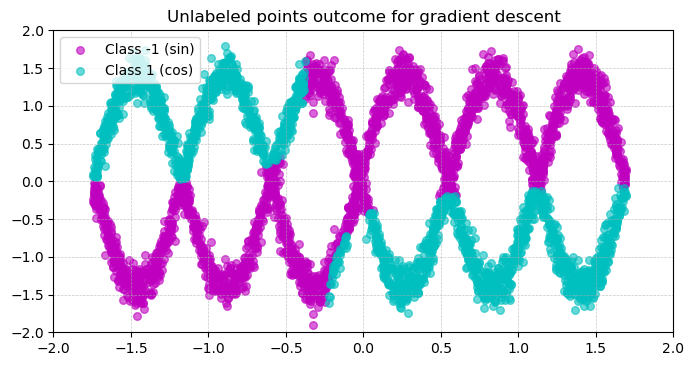

In [147]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Unlabeled points outcome for gradient descent")
final_y_unlabeled = (y_unlabeled_gd/2 + .5).round() * 2 - 1
plt.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]], alpha=0.6, s=30, color="m")     
plt.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]], alpha=0.6, s=30, color="c")
plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

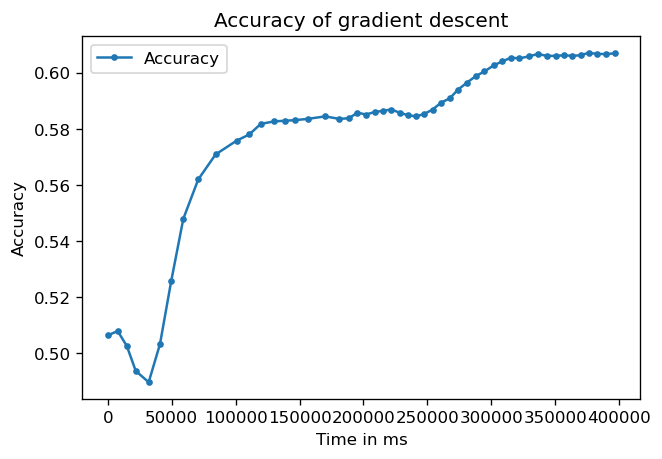

In [158]:
plt.figure(dpi=120)
plt.title("Accuracy of gradient descent")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.legend(["Accuracy"])


In [150]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [ ]:
#Implement the BCGD with GS

NUM_ITERS = 50
EPSILON = 1e-11

ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy2(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li[index], index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(y_unlabeled_target) == 0:
        y_unlabeled_bcgd_gs_hard= np.where(y_unlabeled_bcgd_gs > 0, 1, -1)
        accuracies_bcgd_gs.append(accuracy2(y_unlabeled_bcgd_gs_hard))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 225000 - final accuracy 50.64% - loss 13915111.74
10% - iter 22500 / 225000 - final accuracy 50.00% - loss 708287.40
20% - iter 45000 / 225000 - final accuracy 50.00% - loss 699698.84
30% - iter 67500 / 225000 - final accuracy 50.00% - loss 697458.75
40% - iter 90000 / 225000 - final accuracy 54.38% - loss 696726.72
50% - iter 112500 / 225000 - final accuracy 56.93% - loss 696482.66
60% - iter 135000 / 225000 - final accuracy 57.98% - loss 696404.20
70% - iter 157500 / 225000 - final accuracy 58.44% - loss 696378.49
80% - iter 180000 / 225000 - final accuracy 58.67% - loss 696371.30
90% - iter 202500 / 225000 - final accuracy 59.02% - loss 696368.70

Final accuracy: 60.51%
Norm gradient: 17.020448747886157
Loss: 696367.8063848066



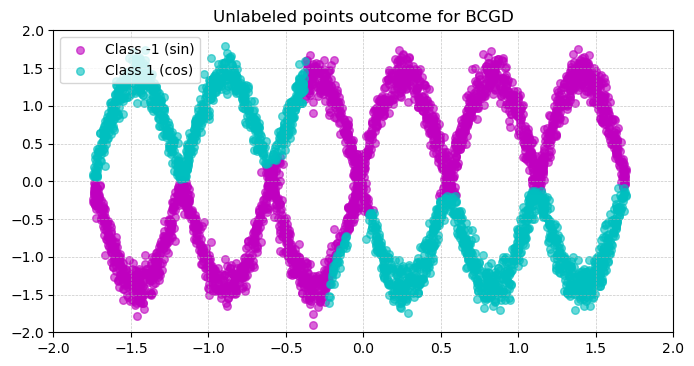

In [ ]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Unlabeled points outcome for BCGD")
final_y_unlabeled_ = (y_unlabeled_bcgd_gs/2 + .5).round() * 2 - 1
plt.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]], alpha=0.6, s=30, color="m")     
plt.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]], alpha=0.6, s=30, color="c")
plt.legend(["Class -1 (sin)", "Class 1 (cos)"])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

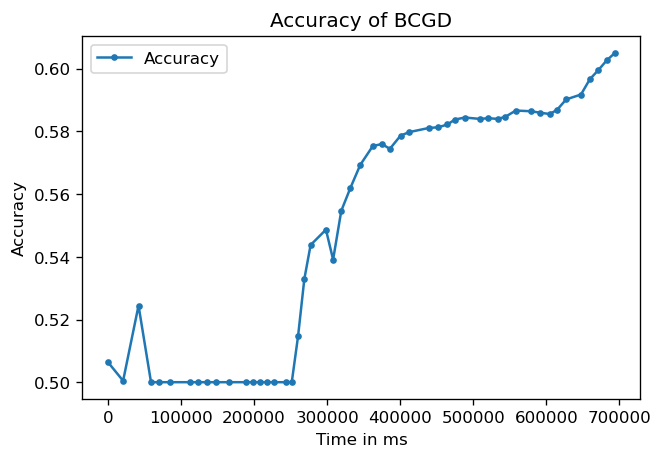

In [159]:
plt.figure(dpi=120)
plt.title("Accuracy of BCGD")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.legend(["Accuracy"])

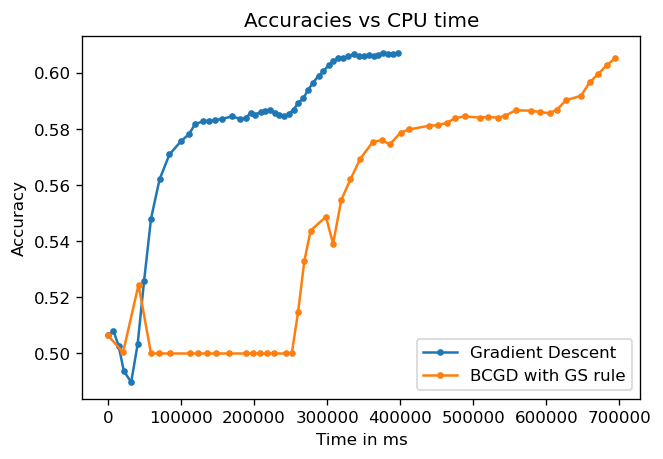

In [160]:
plt.figure(dpi=120)
plt.title("Accuracies vs CPU time")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.legend(["Gradient Descent", "BCGD with GS rule"])